# CITS4404 Practical Project

### Camo Worms!
---
This notebook contains all the code developed for Group 1's CITS4404 Practical Project. To test the developed Genetic Algorithm and cost function, simply run all cells within this notebook and review the final clew outputted.


Please ensure that you have installed the relevant imports:\
`# pip install imageio matplotlib scikit-learn scipy sympy`\
and are running the notebook on Python 3.12.2.

---

<div style="margin-left: 0px">
    &nbsp;
    <img src="CamoWorms/velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

---

## Provided Code

### Imports and Global Variables

In [825]:
# Imports
import random
import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier

from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images

In [826]:
# Global Variables
IMAGE_DIR = 'MendeleyDataset'
IMAGE_NAME='DME-1102486-2'
MASK = [0, 1000, 0, 1000] # ymin ymax xmin xmax
IMAGE_DIR = 'CamoWorms/images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

### Image Preperation

In [827]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

### Camo Worms and Drawing Them

In [828]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[1],point[0]] for point in intermediates]
        return(np.array(colours)/255)


In [829]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()

### Random Worms and Clews

In [830]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

In [831]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

&copy; Cara MacNish, UWA, 2024

---

## Project Code Deliverables

### Cost Function
Group formulated cost function class, with four internal methods. An evaluation method was created to evaluate the cost of each worm in a clew. The overall cost of each worm is considered with respect to three different aspects. The worm's internal performance, the worm's performance relative to other worms, and the worm's performance with respect to its position on the OCT scan.

In [832]:
class CostFunction:
    '''
    To calculate the cost of each worm in the clew.
    '''
    def __init__(self, image, weights, info=True):
        self.image = image
        self.weights = weights
        self.info = info

    def internal_cost(self, worm):
        '''
        Considers standardised ideals for the worm's properties.
        '''
        # Initialise total costs
        total_curvature_cost = 0
        total_curve_angle_cost = 0
        total_length_cost = 0
        total_width_cost = 0
        
        # Only penalise worms that are too curvy for their length
        if abs(worm.dr) > 1.5 * worm.r:
            ideal_curvature = 0.5 * worm.r 
            total_curvature_cost += 0.05 * abs(abs(ideal_curvature) - worm.dr)/ideal_curvature
        
        # Promote worm length
        total_length_cost += 1 / (0.01 * worm.approx_length()) 

        # Promote worm width
        total_width_cost += 1 / (0.05 * worm.width)

        if self.info:
            print(f"------------------------------------------INTERNAL--")
            print(f"Curvature_cost: {total_curvature_cost}")
            print(f"Curvature_Angle_cost: {total_curve_angle_cost}")
            print(f"Length_cost: {total_length_cost}")
            print(f"Width_cost: {total_width_cost}")
        return total_curvature_cost + total_length_cost + total_width_cost + total_curve_angle_cost
    
    def group_cost(self, worm, clew):
        '''
        Considers the effect of clew proximity on the worm.
        '''
        # Initialise total costs
        total_midpoint_overlap_cost = 0

        worm_midpoint = worm.intermediate_points(3)[1]
        clew_midpoints = np.array([w.intermediate_points(3)[1] for w in clew])

        x_space = 0.07 * self.image.shape[1]
        y_space = 0.07 * self.image.shape[0]

        x_LHS = (worm_midpoint[0] - x_space)
        x_RHS = (worm_midpoint[0] + x_space)
        y_lower = (worm_midpoint[1] - y_space)
        y_upper = (worm_midpoint[1] + y_space)

        x_space_invasion = np.where((x_LHS < clew_midpoints[:, 0]) & (clew_midpoints[:, 0] < x_RHS))
        y_space_invasion = np.where((y_lower < clew_midpoints[:, 1]) & (clew_midpoints[:, 1] < y_upper))

        space_invasion = np.where((x_LHS < clew_midpoints[:, 0]) & (clew_midpoints[:, 0] < x_RHS) & 
                                   (y_lower < clew_midpoints[:, 1]) & (clew_midpoints[:, 1] < y_upper))
    
        total_midpoint_overlap_cost += (len(x_space_invasion[0]) - 1)
        total_midpoint_overlap_cost += 1.5 * (len(y_space_invasion[0]) + len(space_invasion[0]) - 2) 
        
        if self.info:
            print(f"---------------------------------------------GROUP--")
            print(f"x_space: {x_space}, y_space: {y_space}")
            print(x_space_invasion[0], y_space_invasion[0])
            print(space_invasion[0])
            print(f"Midpoint_Overlap_cost: {total_midpoint_overlap_cost}")
        return total_midpoint_overlap_cost
    
    def environment_cost(self, worm):
        '''
        Considers the effect of the image on the worm's properties.
        '''
        if self.info: print(f"-----------------------------------------------ENV--")
        
        # Initialise total costs
        total_colour_cost = 0
        total_out_of_bounds_cost = 0
        total_edge_cost = 0
        total_location_cost = 0
        total_width_cost = 0

        # Get all points along the worm's path
        num_points = max(int(worm.approx_length() / (worm.width)), 1)
        path = worm.intermediate_points(num_points)

        # Get worm's colour and width
        colour = worm.colour
        width = int(worm.width)
        checked_points = []
        total_colour_cost_added = 0

        # Calculate colour adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))

            for dx in range(-width, width + 1):
                for dy in range(-width, width + 1):
                    if (dx, dy) not in checked_points:
                        checked_points.append((dx, dy))
                        # Check coordinates are within the image bounds
                        nx = max(0, min(int(x + dx), self.image.shape[1] - 1))
                        ny = max(0, min(int(y + dy), self.image.shape[0] - 1))

                        # Calculate the distance between current point and the worm's closest intermediate point
                        distance = np.sqrt((x - nx) ** 2 + (y - ny) ** 2)

                        # If the distance is less than the worm's width, calculate the color difference
                        if distance <= width:
                            # Calculate colour difference between worm and image at each point
                            image_colour = self.image[ny, nx].astype(float) / 255
                            colour_difference = np.linalg.norm(colour - image_colour)
            
                            # Accumulate colour adaptation cost
                            total_colour_cost += colour_difference
                            total_colour_cost_added += 1

        total_colour_cost = 25 * (total_colour_cost / total_colour_cost_added)

        # Get points along the worm's path
        detail = 100
        path_colours = [[],[]]
        path = np.array(worm.intermediate_points(detail))

        # Calculate color adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            if (int(x) > (self.image.shape[1] - 1)) or (int(x) < 0):
                total_out_of_bounds_cost += 0.07
            if (int(y) > (self.image.shape[0] - 1)) or (int(y) < 0):
                total_out_of_bounds_cost += 0.07
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))

            # Record the intensity at each point
            pixel_colour = self.image[y, x].astype(float) / 255
            path_colours[1].append([x,y])
            path_colours[0].append(pixel_colour)

        # Calculate the intesity gradients and related cost
        gradients = abs(np.diff(path_colours[0]))
        if len(gradients) > 0:
            edge_threshold = np.percentile(gradients, 85)
            edge_points = len(np.where(gradients >= edge_threshold)[0])
            
            if self.info: print(f"Max_Edge_gradient: {max(gradients)}")
            if self.info: print(f"Edge_points: {edge_points}")

            if edge_points > 0.3 * detail :
                # The edges make up 30% of the worm
                total_edge_cost += 0.1 * edge_points

        # Calculate worm colour deviation cost 
        colour_deviation = np.std(path_colours[0])
        if colour_deviation:
            if colour_deviation > 0.07:
                # Too much colour deviation means it's over a lot of noise
                total_location_cost += 100 * colour_deviation
                total_location_cost += 0.1 * abs(0.1 * worm.r - worm.approx_length())
            else:
                # Not much deviation means that the worm has room to grow in width
                total_width_cost += 1 / (0.5 * worm.width)
    
        if self.info:
            print(f"Colour_deviation: {colour_deviation}")
            print(f"Colour_cost: {total_colour_cost}")
            print(f"Edge_cost: {total_edge_cost}")
            print(f"OutOfBounds_cost: {total_out_of_bounds_cost}")
            print(f"Width_cost: {total_width_cost}")
            print(f"Location_cost: {total_location_cost}")
        return total_colour_cost + total_edge_cost + total_out_of_bounds_cost + total_location_cost + total_width_cost
    
    def evaluate (self, clew):
        '''
        Calculate the collective cost for each worm in the clew, and returns an array of their costs.
        '''
        # Initialise variables
        total_cost = []
        count = 0
        
        for worm in clew:
            if self.info:
                # Testing: Display Worm information
                print(f"====================================================")
                print(f"Worm No.{count}")
                print(f"({worm.x}, {worm.y})")

            # Calculate and add collective costs for each worm
            internal = self.weights["internal"] * self.internal_cost(worm)
            group = self.weights["group"] * self.group_cost(worm, clew)
            environment = self.weights["environment"] * self.environment_cost(worm)
            total_cost.append(internal + group + environment)

            count += 1

            if self.info:
                print(f"----------------------------------------------------")
                print(f"[i]\tTotal Internal: {internal}")
                print(f"[g]\tTotal Group: {group}")
                print(f"[e]\tTotal Environment: {environment}")
                print(f"[!]\tWORM COST: {internal + group + environment}")
                print(f"====================================================\n")

        if self.info:
            drawing = Drawing(self.image)
            for w in clew:
                drawing.add_worms(w)
                drawing.add_dots(w.control_points(),color='orange')

            temp = total_cost
            index = np.argmin(temp)
            print(f"Best Worm is No. {index} with cost: {temp[index]:.2f}")
            drawing.add_worms(clew[index])
            drawing.add_dots(clew[index].control_points(),color='blue')
            
            index = np.argmax(temp)
            print(f"Worst Worm is No. {index} with cost: {temp[index]:.2f}")
            drawing.add_worms(clew[index])
            drawing.add_dots(clew[index].control_points(),color='red')

            print(f"Median Worm cost: {np.mean(temp):.2f}")

            drawing.show()
        return total_cost
            


### Genetic Algorithm

In [833]:
class GeneticAlgorithm:
    def __init__(self, image, population_size, crossover_rate, mutation_rate, weights):
        self.image = image
        self.population_size = population_size 
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.weights = weights

    def initialise_population(self, image_shape, init_params):
        population = [random_worm(image_shape, init_params) for _ in range(self.population_size)]
        return population

    def select_parents(self, population, parent_cost):
        # Select parents based on fitness
        tournament_size = 3
        parents = []
        for _ in range(self.population_size):
            tournament_indices = np.random.choice(range(len(population)), tournament_size, replace=False)
            tournament = [population[i] for i in tournament_indices]
            tournament_cost = [parent_cost[i] for i in tournament_indices]
            winner = tournament[np.argmin(tournament_cost)]
            parents.append(winner)
        return parents

    def crossover(self, parent1, parent2):
        # Crossover parents to create offspring
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
        # Get other parameters from parents
        p1 = np.zeros(len(params))
        p2 = np.zeros(len(params))
        for i, param in enumerate(params):
            if random.random() < self.crossover_rate:
                p1[i] = getattr(parent2, param)
                p2[i] = getattr(parent1, param)
            else:
                p1[i] = getattr(parent1, param)
                p2[i] = getattr(parent2, param)
        
        return p1, p2

    def mutate(self, worm_params, init_params):
        # Mutate offspring
        # Randomly select any parameters of the worm and mutate it
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
        # costs = np.average(parent_costs) / lowest_cost
        (radius_std, deviation_std, width_theta) = init_params

        for i, param in enumerate(params):
            if random.random() < self.mutation_rate :
                if param == 'x':
                    worm_params[i] = self.image.shape[1] * rng.random()
                elif param == 'y':
                    worm_params[i] = self.image.shape[0] * rng.random()
                elif param == 'r':
                    worm_params[i] = radius_std * np.abs(rng.standard_normal())
                elif param == 'theta':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'dr':
                    worm_params[i] = deviation_std * np.abs(rng.standard_normal())
                elif param == 'dgamma':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'width':
                    worm_params[i] = width_theta * rng.standard_gamma(3)
                elif param == 'colour':
                    worm_params[i] = rng.random()
        return worm_params
    
    def run(self, max_generations, init_params):
        # Initialize population
        population = self.initialise_population(self.image.shape, init_params)
        drawing = Drawing(self.image)
        drawing.add_worms(population)
        drawing.show()

        cost = CostFunction(self.image, self.weights, False)

        # ------------ Add Cost_function to offspring------------
        for generation in range(max_generations):
            # Evaluate the cost of each worm in the parent population
            parent_costs = cost.evaluate(population)

            # Select parents
            parents = self.select_parents(population, parent_costs)

            # Create offspring through crossover
            offspring = []
            for i in range(0, self.population_size, 2):
                child_param1, child_param2 = self.crossover(parents[i], parents[i+1])
                child_param1 = self.mutate(child_param1, init_params)
                child_param2 = self.mutate(child_param2, init_params)
                child1 = Camo_Worm(*child_param1)
                child2 = Camo_Worm(*child_param2)
                offspring.extend([child1, child2])
            
            # Add parents and offspring together
            new_population = population + offspring

            # Evaluate the cost of each worm in the new population
            pop_cost = cost.evaluate(new_population)

            # Get the indices of worms sorted by their costs in ascending order
            sorted_indices = sorted(range(len(pop_cost)), key=lambda k: pop_cost[k])
            sorted_population = [new_population[i] for i in sorted_indices]

            # Replace old population with new population
            population = sorted_population[:self.population_size]

            if (generation + 1) % 5 == 0 or generation == 0:
                print(f"Generation No.{generation + 1} avg cost: {sum(pop_cost)}")

        return population

### Run Genetic Algorithm

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


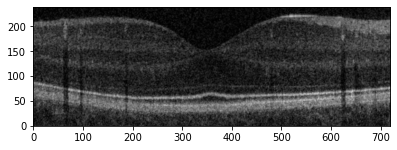

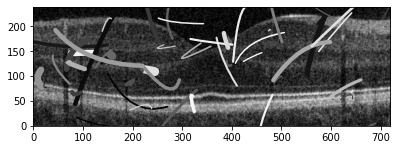

Generation No.1 avg cost: 4643.519521958277
Generation No.5 avg cost: 3608.894533276691
Generation No.10 avg cost: 3222.4919487993598
Generation No.15 avg cost: 3093.323218228608
Generation No.20 avg cost: 3205.5562266735
Generation No.25 avg cost: 3133.525012308001
Generation No.30 avg cost: 2955.31915208238
Generation No.35 avg cost: 2883.8328302932955
Generation No.40 avg cost: 3122.489573850857
Generation No.45 avg cost: 2839.0110999423123
Generation No.50 avg cost: 2986.1651039541784
Generation No.55 avg cost: 2976.1546435814485
Generation No.60 avg cost: 3047.0712206050407
Generation No.65 avg cost: 2883.2106858803004
Generation No.70 avg cost: 3004.9230805033026
Generation No.75 avg cost: 2817.1114285734902
Generation No.80 avg cost: 2909.7231412755673
Generation No.85 avg cost: 2998.6934767534244
Generation No.90 avg cost: 2862.1008940856204
Generation No.95 avg cost: 2683.057873782819
Generation No.100 avg cost: 2858.731012030589


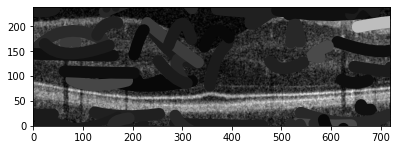

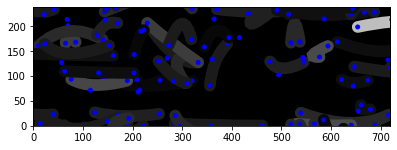

In [834]:
# Load in OCT scan
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Define parameters for the Genetic Algorithm
population_size = 50 # Number of worms in the population ---- to be adjusted
crossover_rate = 0.6 # Probability of crossover
mutation_rate = 0.4 # Probability of mutation`

# Define weights
weights = {'internal': 1.2, 'group': 0.5 , 'environment': 0.8}

# Create an instance of the GeneticAlgorithm class
genetic_algorithm = GeneticAlgorithm(image, population_size, crossover_rate, mutation_rate, weights)

# Define initial parameters for the worms
init_params = (40, 30, 1)  # Example parameters, adjust as needed

# Define the maximum number of generations
max_generations = 100 
clew = genetic_algorithm.run(max_generations, init_params)

# Display the optimized population of worms
drawing = Drawing(image)
for worm in clew:
    drawing.add_worms(worm)
drawing.show()

# Display the optimized population of worms with a black background
blank_drawing = Drawing(np.full((image.shape[0], image.shape[1]), 1, dtype=np.uint8))
for worm in clew:
    blank_drawing.add_worms(worm)
    blank_drawing.add_dots(worm.control_points(),color='blue')
blank_drawing.show()